# Filtering higher-order datasets

This notebook accompanies "Filtering higher-order datasets" by Nicholas W. Landry, Ilya Amburg, Mirah Shi, and Sinan G. Aksoy.

The following notebook extensively uses the [XGI](https://xgi.readthedocs.io/) software package.

In [29]:
import copy
import math
import warnings
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as stats
import xgi
from scipy.optimize import linear_sum_assignment
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import json
import os
import seaborn as sns
from matplotlib.colors import ListedColormap

warnings.filterwarnings("ignore")

In [3]:
# Make directories if they don't exist
if not os.path.exists("Data"):
    os.mkdir("Data")
if not os.path.exists("Figures"):
    os.mkdir("Figures")

### Loading datasets

We load all the datasets in this study from the [xgi-data repository](https://gitlab.com/complexgroupinteractions/xgi-data) using a function from [XGI](https://xgi.readthedocs.io/). The algorithms in this notebook may be applied to any dataset, but the following cell handles loading datasets from xgi-data.

In [19]:
# Load dataset

dataset_name = "email-enron"
# dataset_name = "email-eu"
# dataset_name = "disgenenet"
# dataset_name = "diseasome"
# dataset_name = "contact-primary-school"
# dataset_name = "contact-high-school"

dataset = xgi.load_xgi_data(dataset_name, max_order=17)

### Cleaning the dataset

We remove isolated nodes, multiedges, and singletons.

In [20]:
# remove isolates, singletons, multiedges, and loops

# Use the dual instead of the original hypergraph in some cases.

# dataset = dataset.dual()
dataset.cleanup()


# This line filters out edge sizes that we wish to exclude from our filtered datasets.
# For the email-enron dataset, for example, there is a single edge that is larger than
# 18 and it has a size of 37.
# dataset = xgi.subhypergraph(
#     dataset, edges=dataset.edges.filterby("size", 20, "leq")
# ).copy()

nodes = list(dataset.nodes)
(dataset.num_nodes, dataset.num_edges)

(143, 1457)

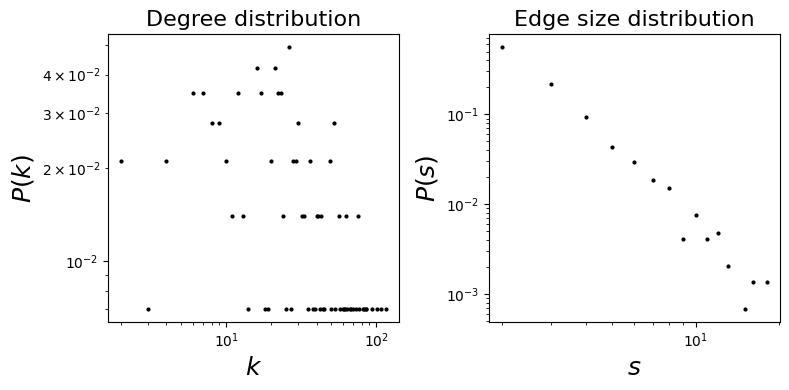

In [21]:
# Here we plot the degree and edge size distributions
axis_label_fontsize = 18
title_fontsize = 16

plt.figure(figsize=(8, 4))

plt.subplot(121)
degrees, counts = np.unique(dataset.nodes.degree.asnumpy(), return_counts=True)
plt.loglog(degrees, counts / dataset.num_nodes, "ko", markersize=2)
plt.title("Degree distribution", fontsize=title_fontsize)
plt.xlabel(r"$k$", fontsize=axis_label_fontsize)
plt.ylabel(r"$P(k)$", fontsize=axis_label_fontsize)

plt.subplot(122)
sizes, counts = np.unique(dataset.edges.size.asnumpy(), return_counts=True)
plt.loglog(sizes, counts / dataset.num_edges, "ko", markersize=2)
plt.title("Edge size distribution", fontsize=title_fontsize)
plt.xlabel(r"$s$", fontsize=axis_label_fontsize)
plt.ylabel(r"$P(s)$", fontsize=axis_label_fontsize)

plt.tight_layout()
plt.show()

### Generating sets of filterings

We create filtering sets (lists of hypergraphs) by only keeping the hyperedges that satisfy the relationship specified in the `filterby()` function. We do this for four different types of filtering.

In [22]:
filtering_parameters = np.arange(
    dataset.edges.size.min(), dataset.edges.size.max() + 1, 1, dtype=int
)

uniform_filtering = [
    xgi.subhypergraph(dataset, edges=dataset.edges.filterby("size", k, "eq")).copy()
    for k in filtering_parameters
]
geq_filtering = [
    xgi.subhypergraph(dataset, edges=dataset.edges.filterby("size", k, "geq")).copy()
    for k in filtering_parameters
]
leq_filtering = [
    xgi.subhypergraph(dataset, edges=dataset.edges.filterby("size", k, "leq")).copy()
    for k in filtering_parameters
]
exclusion_filtering = [
    xgi.subhypergraph(dataset, edges=dataset.edges.filterby("size", k, "neq")).copy()
    for k in filtering_parameters
]
filterings = {
    "uniform": uniform_filtering,
    "GEQ": geq_filtering,
    "LEQ": leq_filtering,
    "exclusion": exclusion_filtering,
}

### Visualizing uniform filterings

Here we visualize hypergraphs for different edge sizes.

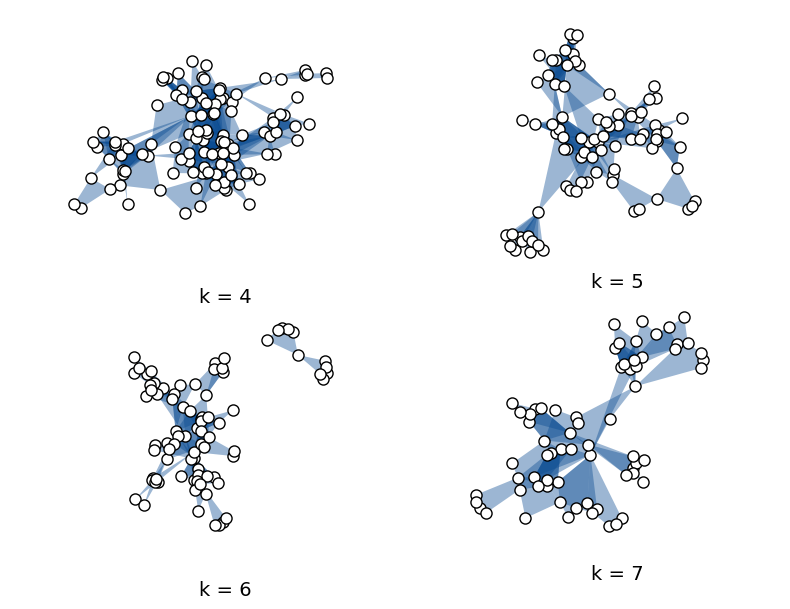

In [8]:
plt.figure(figsize=(8, 6))

# Edge sizes to plot
plot_sizes = [4, 5, 6, 7]

size_dict = dict(zip(filtering_parameters, range(len(uniform_filtering))))

# This sets the random number generator so that the results are the same
# every time they are run. The keys match the values in plot_sizes.
seeds = {4: 2, 5: 0, 6: 2, 7: 1}

plot_index = 1
for k in plot_sizes:
    H = uniform_filtering[size_dict[k]]

    # Remove the isolated nodes when plotting.
    H = xgi.subhypergraph(H, nodes=set(H.nodes) - set(H.nodes.isolates())).copy()
    plt.subplot(2, 2, plot_index)
    plt.text(0.0, -1.3, f"k = {k}", fontsize=14)
    ax = plt.gca()
    xgi.draw(H, xgi.barycenter_spring_layout(H, seed=seeds[k]), node_size=8)
    plt.xlim([-1.1, 1.1])
    plt.ylim([-1.1, 1.1])
    plot_index += 1
plt.tight_layout()
# plt.savefig(f"Figures/{dataset_name}_viz.pdf", dpi=1000)
# plt.savefig(f"Figures/{dataset_name}_viz.png", dpi=1000)
plt.show()

### Effective information

The following computes the effective information for a filtering set.

In [9]:
def get_effective_information(filtering):
    K = len(filtering)
    infos = []
    for k in range(K):
        print(k)
        try:
            H = filtering[k]

            # This algorithm is the effective information defined
            # in "The Emergence of Informative Higher Scales in Complex Networks"
            # by Klein and Hoel, applied to the weighted clique projection of the hypergraph.
            I = xgi.incidence_matrix(H, sparse=True)

            # exclude isolated nodes
            present_nodes = np.sort(np.unique(I.nonzero()[0]))
            I = I[present_nodes, :]

            # form the adjacency matrix
            A = I.dot(I.T)
            n = A.shape[0]
            P = lil_matrix((n, n))
            d = np.sum(A, axis=0)

            P = A / d
            Wavg = np.zeros(n)
            for i in range(n):
                Wavg[i] = np.sum(P[:, i]) / n
            first = stats.entropy(Wavg, base=2)
            second = (
                np.sum(
                    [
                        stats.entropy([P[i, j] for j in range(n)], base=2)
                        for i in range(n)
                    ]
                )
                / n
            )
            infos.append((first - second) / np.log2(n))
        except:
            infos.append(np.NaN)
    return infos

In [10]:
try:
    with open(f"Data/{dataset_name}_effective_information.json") as file:
        effective_information = json.loads(file.read())
except:
    effective_information = dict()
    for i, f in enumerate(filterings):
        print("filtering ", i)
        effective_information[f] = get_effective_information(filterings[f])

    datastring = json.dumps(effective_information, indent=2)
    with open(f"Data/{dataset_name}_effective_information.json", "w") as output_file:
        output_file.write(datastring)

filtering  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
filtering  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
filtering  2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
filtering  3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


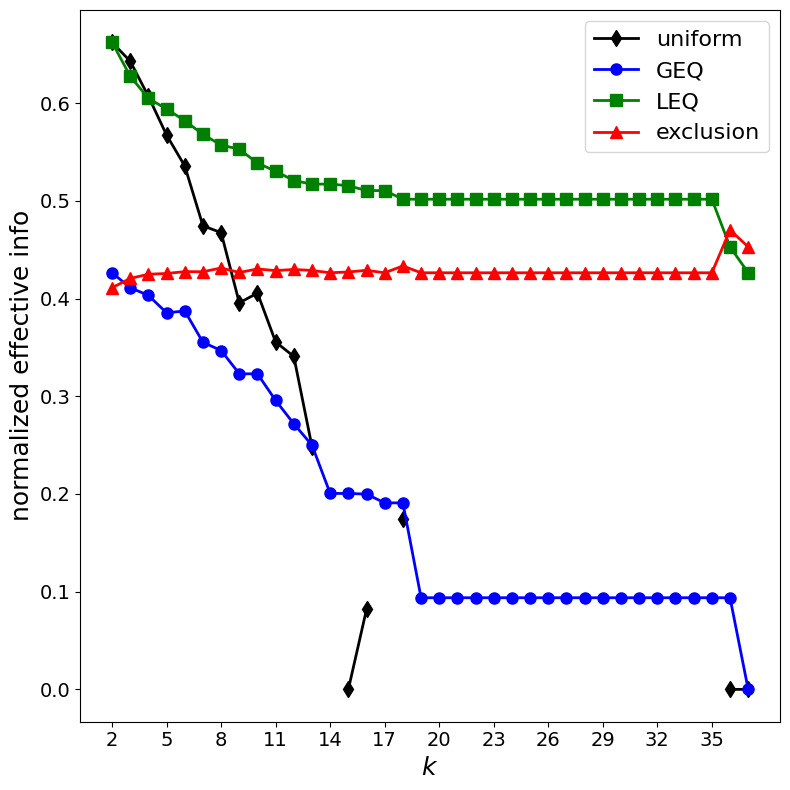

In [12]:
# Here we plot the effective information for the four different types of filtering.

tick_fontsize = 14
axis_label_fontsize = 18
legend_fontsize = 16
title_fontsize = 16
xtick_skip = {
    "email-enron": 3,
    "email-eu": 10,
    "disgenenet": 3,
    "diseasome": 2,
    "contact-primary-school": 1,
    "contact-high-school": 1,
}

plt.figure(figsize=(8, 8))

specs = {"uniform": "kd-", "GEQ": "bo-", "LEQ": "gs-", "exclusion": "r^-"}

for label, ei in effective_information.items():
    plt.plot(
        filtering_parameters, ei, specs[label], label=label, linewidth=2, markersize=8
    )

plt.xticks(filtering_parameters[:: xtick_skip[dataset_name]], fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(fontsize=legend_fontsize, loc="upper right")
plt.xlabel(r"$k$", fontsize=axis_label_fontsize)
plt.ylabel("normalized effective info", fontsize=axis_label_fontsize)

plt.tight_layout()

plt.savefig(f"Figures/{dataset_name}_effective-info.png", dpi=1000)
plt.savefig(f"Figures/{dataset_name}_effective-info.pdf", dpi=1000)
plt.show()

### Assortativity

Here we compute the degree assortativity according to the definitions in "Configuration models of random hypergraphs" by Phil Chodrow and "Hypergraph assortativity: a dynamical systems perspective" by Landry and Restrepo. All of these functions are implemented in XGI.

In [13]:
def get_assortativity(filtering, assortativity_fcn, **kwargs):
    a = np.zeros(len(filtering))
    for i in range(len(filtering)):
        try:
            a[i] = assortativity_fcn(filtering[i], **kwargs)
        except:
            a[i] = np.NaN
    return a

In [14]:
# dynamical assortativity
da = dict()
# top-2 assortativity
tta = dict()
# top-bottom assortativity
tba = dict()
# uniform assortativity
ua = dict()

try:
    with open(f"Data/{dataset_name}_dynamical_assortativity.json") as file:
        da = json.loads(file.read())
    with open(f"Data/{dataset_name}_top-2_assortativity.json") as file:
        tta = json.loads(file.read())
    with open(f"Data/{dataset_name}_top-bottom_assortativity.json") as file:
        tba = json.loads(file.read())
    with open(f"Data/{dataset_name}_uniform_assortativity.json") as file:
        ua = json.loads(file.read())
except:
    for label in filterings:
        f = filterings[label]
        da[label] = list(get_assortativity(f, xgi.dynamical_assortativity))
        tta[label] = list(get_assortativity(f, xgi.degree_assortativity, kind="top-2"))
        tba[label] = list(
            get_assortativity(f, xgi.degree_assortativity, kind="top-bottom")
        )
        ua[label] = list(get_assortativity(f, xgi.degree_assortativity, kind="uniform"))

    datastring = json.dumps(da, indent=2)
    with open(f"Data/{dataset_name}_dynamical_assortativity.json", "w") as output_file:
        output_file.write(datastring)
    datastring = json.dumps(tta, indent=2)
    with open(f"Data/{dataset_name}_top-2_assortativity.json", "w") as output_file:
        output_file.write(datastring)
    datastring = json.dumps(tba, indent=2)
    with open(f"Data/{dataset_name}_top-bottom_assortativity.json", "w") as output_file:
        output_file.write(datastring)
    datastring = json.dumps(ua, indent=2)
    with open(f"Data/{dataset_name}_uniform_assortativity.json", "w") as output_file:
        output_file.write(datastring)

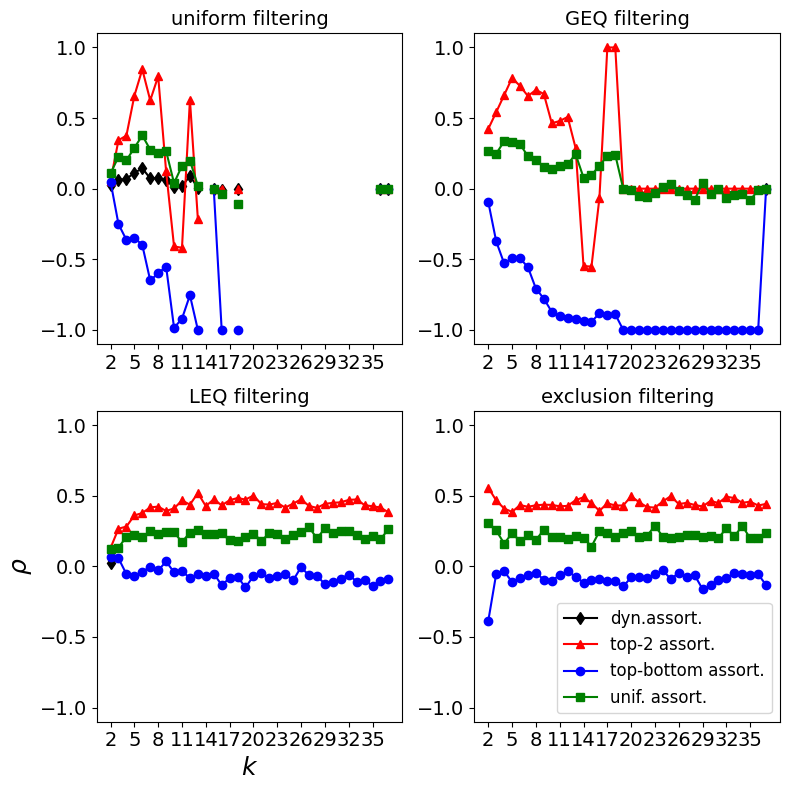

In [15]:
# Plot the assortativity for the four different types of filtering.
tick_fontsize = 14
axis_label_fontsize = 18
legend_fontsize = 12
title_fontsize = 16
xtick_skip = {
    "email-enron": 3,
    "email-eu": 10,
    "disgenenet": 3,
    "diseasome": 2,
    "contact-primary-school": 1,
    "contact-high-school": 1,
}

plt.figure(figsize=(8, 8))

for i, label in enumerate(filterings):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{label} filtering", fontsize=14)
    plt.plot(filtering_parameters, da[label], "kd-", label="dyn.assort.")
    plt.plot(filtering_parameters, tta[label], "r^-", label="top-2 assort.")
    plt.plot(filtering_parameters, tba[label], "bo-", label="top-bottom assort.")
    plt.plot(filtering_parameters, ua[label], "gs-", label="unif. assort.")

    plt.xticks(
        filtering_parameters[:: xtick_skip[dataset_name]], fontsize=tick_fontsize
    )
    plt.ylim([-1.1, 1.1])
    plt.yticks(np.linspace(-1, 1, 5), fontsize=tick_fontsize)
    if i == 2:
        plt.xlabel(r"$k$", fontsize=axis_label_fontsize)
        plt.ylabel(r"$\rho$", fontsize=axis_label_fontsize)
    if i == 3:
        plt.legend(fontsize=legend_fontsize, loc="lower right")

plt.tight_layout()
plt.savefig(f"Figures/{dataset_name}_assortativity.pdf", dpi=1000)
plt.savefig(f"Figures/{dataset_name}_assortativity.png", dpi=1000)
plt.show()

### Community structure

The following block of code takes a filtering, computes the Laplacian, and performs spectral k-means clustering on it, according to the algorithm presented in "Learning with Hypergraphs: Clustering, Classification, and Embedding" by Zhou, Huang, and Schölkopf.

In [23]:
# Compute the normalized Laplacian.
def get_normalized_laplacian(H):
    I = xgi.incidence_matrix(H)
    present_nodes = np.sort(np.unique(I.nonzero()[0]))
    I = I[present_nodes, :]
    # A = I I^T
    A = I.dot(I.T)
    n = A.shape[0]
    # zero the diagonal
    A = A - diags(A.diagonal())
    degrees = np.sum(A, axis=1)
    d = []
    for i in range(n):
        d.append(degrees[i])

    # Compute the D^(-1/2) degree matrix.
    d = [1 / math.sqrt(degree) for degree in d]
    D = diags(d)
    A = D @ A @ D
    In = diags([1.0 for i in range(n)])
    L = 0.5 * (In - A)
    return present_nodes, L


# Perform k-means clustering on the eigenvectors of the
# Laplacian of a hypergraph.
def get_zhou_clusters(H, m):
    try:
        present_nodes, L = get_normalized_laplacian(H)
        _, v = eigsh(L, k=m, which="SM")
        kmeans = KMeans(n_clusters=m).fit(v)
        return present_nodes, kmeans.labels_
    except:
        return [], m * np.ones(H.num_nodes)


# Get the community labels for each hypergraph in the filtering set.
def get_communities(filtering, m):
    K = len(filtering)
    n = filtering[0].num_nodes
    community_labels = np.zeros([K, n])
    community_labels[:] = m
    for i in range(K):
        print(i)
        present_nodes, labels = get_zhou_clusters(filtering[i], m)
        for (j, node) in enumerate(present_nodes):
            community_labels[i, node] = labels[j]

    return community_labels


# convert a vector of community labels to
def get_clusters_from_label_vector(labels, m):
    label_dict = {}
    clusters = []
    for i in range(len(labels)):
        if labels[i] not in label_dict and labels[i] != m:
            label_dict[labels[i]] = [i]
        elif labels[i] != m:
            label_dict[labels[i]].append(i)
    for i in np.sort(list(label_dict.keys())):
        clusters.append(label_dict[i])
    return clusters


# perform hungarian matching to permute the community labels
# so that the overlap between community labels is as consistent
# as possible.
def hungarian_matching(c1, c2):
    n = len(c1)
    if len(c1) != len(c2):
        print("clusterings are not of the same length!")
    C = []
    for i in range(n):
        C.append([])
    for i in range(n):
        for j in range(n):
            if len(set(c1[i]).union(set(c2[j]))) > 0:
                set_diff_frac = (
                    -0.5
                    * (len(c1[i]) + len(c2[j]))
                    * len(set(c1[i]).intersection(set(c2[j])))
                    / len(set(c1[i]).union(set(c2[j])))
                )
            else:
                set_diff_frac = 1000
            cost = set_diff_frac
            C[i].append(cost)
    index_1, index_2 = linear_sum_assignment(C)
    return index_1, index_2


def get_val(d, key):
    # to consistently relabel from 0
    if key not in d:
        n = len(d)
        d[key] = n
        return n
    return d[key]


# permute the community labels of an entire filtering set (using hungarian
# matching) so that the community labels are roughly consistent across the filtering parameters.
def match_communities(community_labels, m):
    ## community_labels is K arrays of length n each, each encoding the community labels for each filtering
    K = len(community_labels)
    for i in range(K - 1):
        current_labels = community_labels[i]
        next_labels = community_labels[i + 1]
        # get clusters of nodes (list of lists)
        current_clusters = get_clusters_from_label_vector(current_labels, m)
        next_clusters = get_clusters_from_label_vector(next_labels, m)
        # rearrange labels of next_clusters to most closely line up with that of current clusters
        old_index, new_index = hungarian_matching(current_clusters, next_clusters)
        label_map = dict(zip(new_index, old_index))
        for j in range(len(next_labels)):
            # nodes with a label of m must not be assigned to another cluster since they correspond to missing nodes
            if (next_labels[j] != m) & (current_labels[j] != m):
                next_labels[j] = label_map[next_labels[j]]
        community_labels[i + 1] = copy.deepcopy(next_labels)
    first = copy.deepcopy(community_labels[0])
    # print(np.unique(np.array(first)))
    first_clusters = get_clusters_from_label_vector(first, m)
    # print(len(first_clusters))
    cluster_length = []
    for (i, cluster) in enumerate(first_clusters):
        cluster_length.append(len(cluster))
    # get ranming of clusters by size
    cluster_ranm = np.flip(np.argsort(cluster_length))
    # print(cluster_ranm)
    ranm_label_map = dict(zip(cluster_ranm, [i for i in range(len(cluster_ranm))]))
    for (i, label) in enumerate(first):
        try:
            first[i] = ranm_label_map[int(label)]
        except:
            continue
    index = np.argsort(first)
    color_map = {}
    for (i, c) in enumerate(community_labels):
        community_labels[i] = c[index]
        for (j, c_) in enumerate(c):
            if community_labels[i][j] != m:
                community_labels[i][j] = get_val(color_map, c_)
    for i in range(len(community_labels)):
        for j in range(len(community_labels[i])):
            if community_labels[i][j] == m:
                community_labels[i][j] = np.NaN
    return community_labels, index


# permute the community labels of an entire filtering set (using hungarian
# matching) so that the community labels are roughly consistent across the filtering parameters,
# based on the results of the GEQ filtering.
def match_communities_node_reordering_on_geq(community_labels, m, index, c_geq):
    ## community_labels is m arrays of length n each, each encoding the community labels for each filtering
    K = len(community_labels)
    for i in range(K - 1):
        current_labels = community_labels[i]
        next_labels = community_labels[i + 1]

        # get clusters of nodes (list of lists)
        current_clusters = get_clusters_from_label_vector(current_labels, m)
        next_clusters = get_clusters_from_label_vector(next_labels, m)

        # rearrange labels of next_clusters to most closely line up with that of current clusters
        # this checks for the case where there are no communities
        if len(current_clusters) == len(next_clusters):
            old_index, new_index = hungarian_matching(current_clusters, next_clusters)
            label_map = dict(zip(new_index, old_index))
            for j in range(len(next_labels)):
                # nodes with a label of k must not be assigned to another cluster since they correspond to missing nodes
                if (next_labels[j] != m) & (current_labels[j] != m):
                    next_labels[j] = label_map[next_labels[j]]
            community_labels[i + 1] = copy.deepcopy(next_labels)

    for (i, c) in enumerate(community_labels):
        community_labels[i] = c[index]
    first = copy.deepcopy(community_labels[0])
    mode = stats.mode(first)[0]
    for j, f in enumerate(first):
        if f == m:
            first[j] = mode
    current_clusters = get_clusters_from_label_vector(first, m)

    geq_clusters = get_clusters_from_label_vector(c_geq, m)

    old_index, new_index = hungarian_matching(current_clusters, geq_clusters)
    label_map = dict(zip(old_index, new_index))

    for i in range(len(community_labels)):
        for j in range(len(community_labels[i])):
            if community_labels[i][j] == m:
                community_labels[i][j] = np.NaN
            else:
                community_labels[i][j] = label_map[community_labels[i][j]]
    return community_labels

In [27]:
# get the community labels
community_labels = dict()
m = {
    "email-enron": 5,
    "email-eu": 42,
    "disgenenet": 22,
    "diseasome": 10,
    "contact-primary-school": 10,
    "contact-high-school": 9,
}

try:
    with open(f"Data/{dataset_name}_zhou_communities.json") as file:
        community_labels = json.loads(file.read())
except:
    _label = "GEQ"
    print(_label)
    f = filterings[_label]
    c = get_communities(f, m[dataset_name])
    c0 = c[0]

    c, index_geq = match_communities(c, m[dataset_name])
    community_labels["GEQ"] = c.tolist()
    all_comm = c[0]

    for label in ["uniform", "LEQ", "exclusion"]:
        print(label)
        f = filterings[label]
        c = get_communities(f, m[dataset_name])
        c = match_communities_node_reordering_on_geq(c, m[dataset_name], index_geq, c0)
        community_labels[label] = c.tolist()

    datastring = json.dumps(community_labels, indent=2)
    with open(f"Data/{dataset_name}_zhou_communities.json", "w") as output_file:
        output_file.write(datastring)

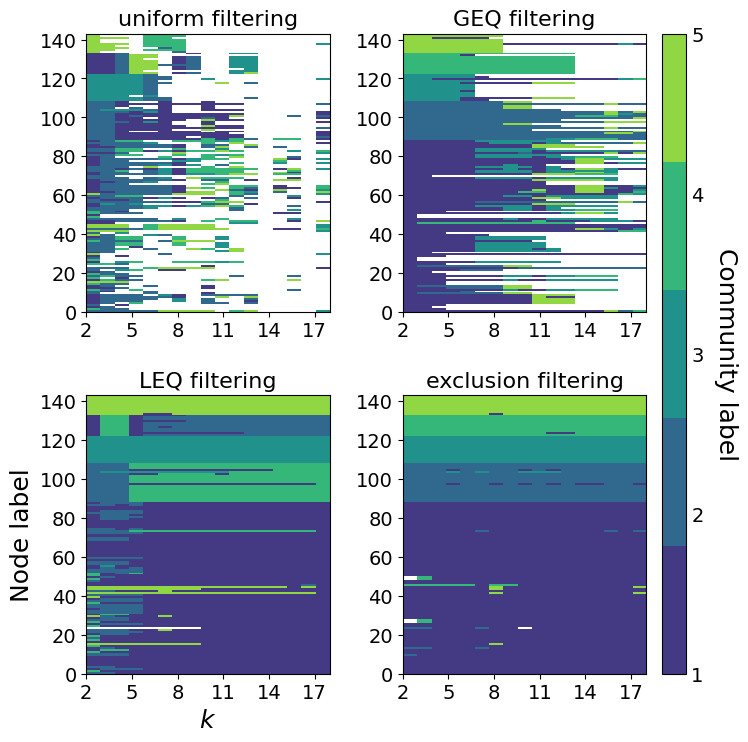

In [30]:
# plot the community labels for each of the four filterings.
custom_palette = ListedColormap(sns.color_palette("viridis", m[dataset_name]).as_hex())
tick_fontsize = 14
axis_label_fontsize = 18
legend_fontsize = 16
title_fontsize = 16
xtick_skip = {
    "email-enron": 3,
    "email-eu": 10,
    "disgenenet": 3,
    "diseasome": 2,
    "contact-primary-school": 1,
    "contact-high-school": 1,
}

ytick_skip = {
    "email-enron": 20,
    "email-eu": 200,
    "disgenenet": 300,
    "diseasome": 100,
    "contact-primary-school": 40,
    "contact-high-school": 60,
}
colorbar_fontsize = 18
colorbar_skip = {
    "email-enron": 1,
    "email-eu": 5,
    "disgenenet": 3,
    "contact-primary-school": 1,
    "contact-high-school": 1,
}

fig = plt.figure(figsize=(8, 8))


for i, label in enumerate(filterings):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{label} filtering", fontsize=title_fontsize)
    # plot the heatmap
    im = plt.imshow(
        np.flipud(np.array(community_labels[label]).T),
        extent=(
            min(filtering_parameters),
            max(filtering_parameters),
            0,
            dataset.num_nodes,
        ),
        aspect="auto",
        interpolation="none",
        rasterized=True,
        cmap=custom_palette,
    )
    plt.xticks(
        filtering_parameters[:: xtick_skip[dataset_name]], fontsize=tick_fontsize
    )
    plt.yticks(nodes[:: ytick_skip[dataset_name]], fontsize=tick_fontsize)

    if i == 2:
        plt.xlabel(r"$k$", fontsize=axis_label_fontsize)
        plt.ylabel("Node label", fontsize=axis_label_fontsize)

fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
# xtick_skip = 1
cbar.set_ticks([i for i in range(m[dataset_name])][:: colorbar_skip[dataset_name]])
cbar.set_ticklabels(
    [i + 1 for i in range(m[dataset_name])][:: colorbar_skip[dataset_name]]
)
cbar.ax.tick_params(labelsize=tick_fontsize, length=0)
cbar.set_label(
    r"Community label", fontsize=colorbar_fontsize, rotation=270, labelpad=25
)

plt.savefig(
    f"Figures/{dataset_name}_zhou_communities.pdf", dpi=1000, bbox_inches="tight"
)
plt.savefig(
    f"Figures/{dataset_name}_zhou_communities.png", dpi=1000, bbox_inches="tight"
)
plt.show()

### Centrality

The following code implements the betweenness centrality as defined in "Hypergraph models of biological networks to identify genes critical to pathogenic viral response" by Feng et al.

In [ ]:
# Compute the betweenness centrality for every hypergraph in a filtering set.
def get_centrality(filtering):
    K = len(filtering)
    n = filtering[0].num_nodes
    c = np.zeros([K, n])
    for i in range(K):
        try:
            hypergraph = filtering[i]
            # compute the betweenness centrality of the unweighted pairwise projection
            A = xgi.adjacency_matrix(hypergraph)
            G = nx.from_scipy_sparse_array(A)
            # we compute the betweenness centrality using NetworkX
            betweenness_dict = nx.betweenness_centrality(G, weight="weight")
            betweenness = np.zeros(len(betweenness_dict))
            for j in range(len(betweenness_dict)):
                betweenness[j] = betweenness_dict[j]

            # normalize with the infinity norm
            maximum = max(betweenness)
            if maximum > 0:
                betweenness /= maximum
            c[i] = betweenness
        except:
            c[i] = 0
    return c

In [ ]:
bc = dict()

try:
    with open(f"Data/{dataset_name}_centrality.json") as file:
        bc = json.loads(file.read())
except:
    for label in filterings:
        f = filterings[label]
        c = get_centrality(f)
        print(label)
        for (i, c_) in enumerate(c):
            print(i)
            c[i] = c_[index_geq]
        bc[label] = c.tolist()
    datastring = json.dumps(bc, indent=2)
    with open(f"Data/{dataset_name}_centrality.json", "w") as output_file:
        output_file.write(datastring)

In [ ]:
# Plot the betweenness centrality.
tick_fontsize = 14
axis_label_fontsize = 18
legend_fontsize = 16
title_fontsize = 16
xtick_skip = {
    "email-enron": 3,
    "email-eu": 10,
    "disgenenet": 3,
    "diseasome": 2,
    "contact-primary-school": 1,
    "contact-high-school": 1,
}
ytick_skip = {
    "email-enron": 20,
    "email-eu": 200,
    "disgenenet": 300,
    "diseasome": 100,
    "contact-primary-school": 40,
    "contact-high-school": 60,
}
colorbar_fontsize = 18

fig = plt.figure(figsize=(8, 8))

for i, label in enumerate(filterings):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{label} filtering", fontsize=title_fontsize)
    # plot the heatmap
    im = plt.imshow(
        np.flipud(np.array(bc[label]).T),
        extent=(
            min(filtering_parameters),
            max(filtering_parameters),
            0,
            dataset.num_nodes,
        ),
        aspect="auto",
        interpolation="none",
        rasterized=True,
    )
    plt.xticks(
        filtering_parameters[:: xtick_skip[dataset_name]], fontsize=tick_fontsize
    )
    plt.yticks(nodes[:: ytick_skip[dataset_name]], fontsize=tick_fontsize)

    if i == 2:
        plt.xlabel(r"$k$", fontsize=axis_label_fontsize)
        plt.ylabel("Node label", fontsize=axis_label_fontsize)

fig.subplots_adjust(bottom=0.15, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.8])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=tick_fontsize)
cbar.set_label(r"$BC(n)$", fontsize=colorbar_fontsize, rotation=270, labelpad=15)

plt.savefig(f"Figures/{dataset_name}_centrality.pdf", bbox_inches="tight")
plt.savefig(f"Figures/{dataset_name}_centrality.png", bbox_inches="tight")
plt.show()